In [15]:
## Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, 
    calinski_harabasz_score, 
    davies_bouldin_score
)
from sklearn.decomposition import PCA

In [2]:
# Baca file CSV
df = pd.read_csv('../data/Copy of default of credit card clients.csv', delimiter=';')

In [3]:
# Pilih fitur untuk clustering
clustering_features = [
    'LIMIT_BAL', 'AGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]


In [4]:
# Preprocessing data untuk clustering
X = df[clustering_features]

In [5]:
# Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Metode Elbow
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

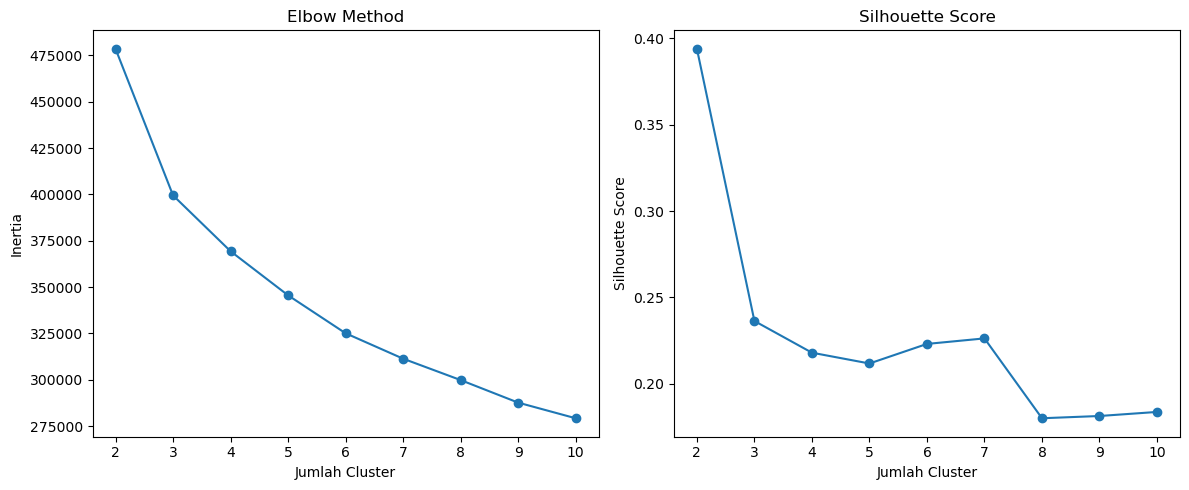

In [7]:
# Visualisasi Elbow Method
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [8]:
# Berdasarkan Elbow Method dan Silhouette Score
optimal_clusters = 4  # Pilih berdasarkan visualisasi

## Lakukan Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

## Analisis Cluster
# Karakteristik setiap cluster
cluster_summary = df.groupby('Cluster').agg({
    'LIMIT_BAL': ['mean', 'median'],
    'AGE': ['mean', 'median'],
    'default payment next month': lambda x: (x == 1).mean() * 100,
    'PAY_0': 'mean',
    'BILL_AMT1': 'mean',
    'PAY_AMT1': 'mean'
})
print("\nRingkasan Karakteristik Cluster:")
print(cluster_summary)

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Ringkasan Karakteristik Cluster:
             LIMIT_BAL                  AGE        default payment next month  \
                  mean    median       mean median                   <lambda>   
Cluster                                                                         
0         77028.140014   50000.0  34.945779   33.0                  62.800275   
1        223741.240456  200000.0  36.689781   35.0                  16.347662   
2        288275.068493  260000.0  37.059857   35.0                  18.165575   
3        119492.623703   80000.0  34.410602   32.0                  18.585445   

            PAY_0      BILL_AMT1      PAY_AMT1  
             mean           mean          mean  
Cluster                                         
0        1.640357   38763.262526   2286.728552  
1       -0.809016    8931.519611   4691.497751  
2        0.212627  204832.195652  16776.151281  
3        0.122821   45918.190725   4380.190725  


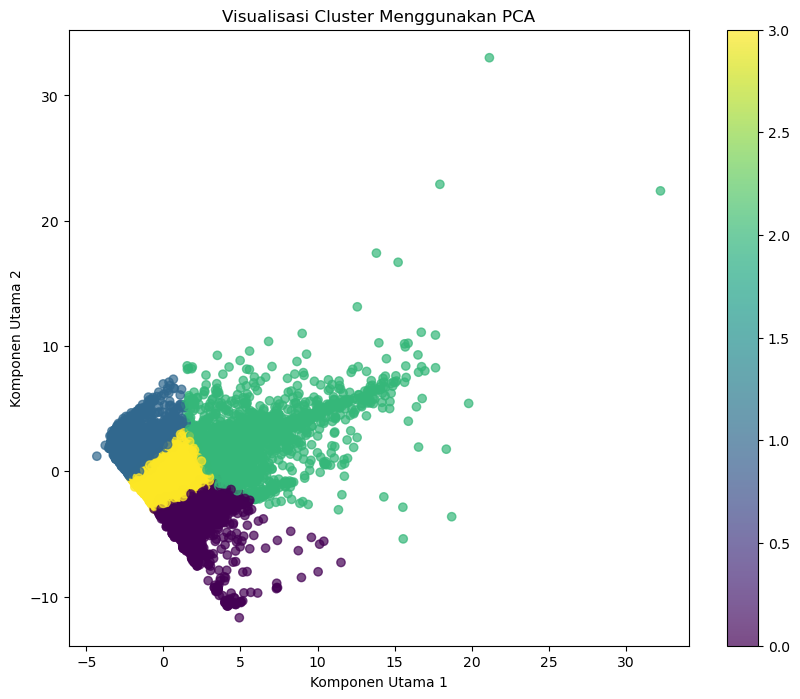

In [9]:
## Visualisasi Cluster
# Reduksi dimensi menggunakan PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot cluster
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=df['Cluster'], 
                      cmap='viridis', 
                      alpha=0.7)
plt.title('Visualisasi Cluster Menggunakan PCA')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(scatter)
plt.show()

In [10]:
## Analisis Default Payment
default_by_cluster = pd.crosstab(df['Cluster'], 
                                  df['default payment next month'], 
                                  normalize='index') * 100
print("\nPersentase Default Payment per Cluster:")
print(default_by_cluster)



Persentase Default Payment per Cluster:
default payment next month          0          1
Cluster                                         
0                           37.199725  62.800275
1                           83.652338  16.347662
2                           81.834425  18.165575
3                           81.414555  18.585445


In [11]:
## Profil Risiko Cluster
def cluster_risk_profile(df):
    risk_profiles = {}
    for cluster in range(optimal_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        
        risk_profiles[cluster] = {
            'Rata-rata Limit Kredit': cluster_data['LIMIT_BAL'].mean(),
            'Rata-rata Umur': cluster_data['AGE'].mean(),
            'Persentase Default': (cluster_data['default payment next month'] == 1).mean() * 100,
            'Rata-rata Pembayaran Tertunda (PAY_0)': cluster_data['PAY_0'].mean()
        }
    
    return pd.DataFrame.from_dict(risk_profiles, orient='index')

risk_profile = cluster_risk_profile(df)
print("\nProfil Risiko Setiap Cluster:")
print(risk_profile)


Profil Risiko Setiap Cluster:
   Rata-rata Limit Kredit  Rata-rata Umur  Persentase Default  \
0            77028.140014       34.945779           62.800275   
1           223741.240456       36.689781           16.347662   
2           288275.068493       37.059857           18.165575   
3           119492.623703       34.410602           18.585445   

   Rata-rata Pembayaran Tertunda (PAY_0)  
0                               1.640357  
1                              -0.809016  
2                               0.212627  
3                               0.122821  


Metrik Performa Clustering:
   n_clusters        inertia  silhouette_score  calinski_harabasz_score  \
0           2  478544.272556          0.393860              7613.567754   
1           3  399460.672054          0.236393              7529.625401   
2           4  369337.510716          0.218052              6244.472466   
3           5  345551.346721          0.211804              5521.751834   
4           6  325087.048456          0.223127              5072.943080   
5           7  311365.481292          0.226320              4633.897911   
6           8  299831.420746          0.180126              4289.389402   
7           9  287662.661575          0.181429              4070.442589   
8          10  279224.569040          0.183775              3828.087155   

   davies_bouldin_score  
0              1.375667  
1              1.415541  
2              1.459627  
3              1.506383  
4              1.721575  
5              1.618602  
6              1.652090  
7            

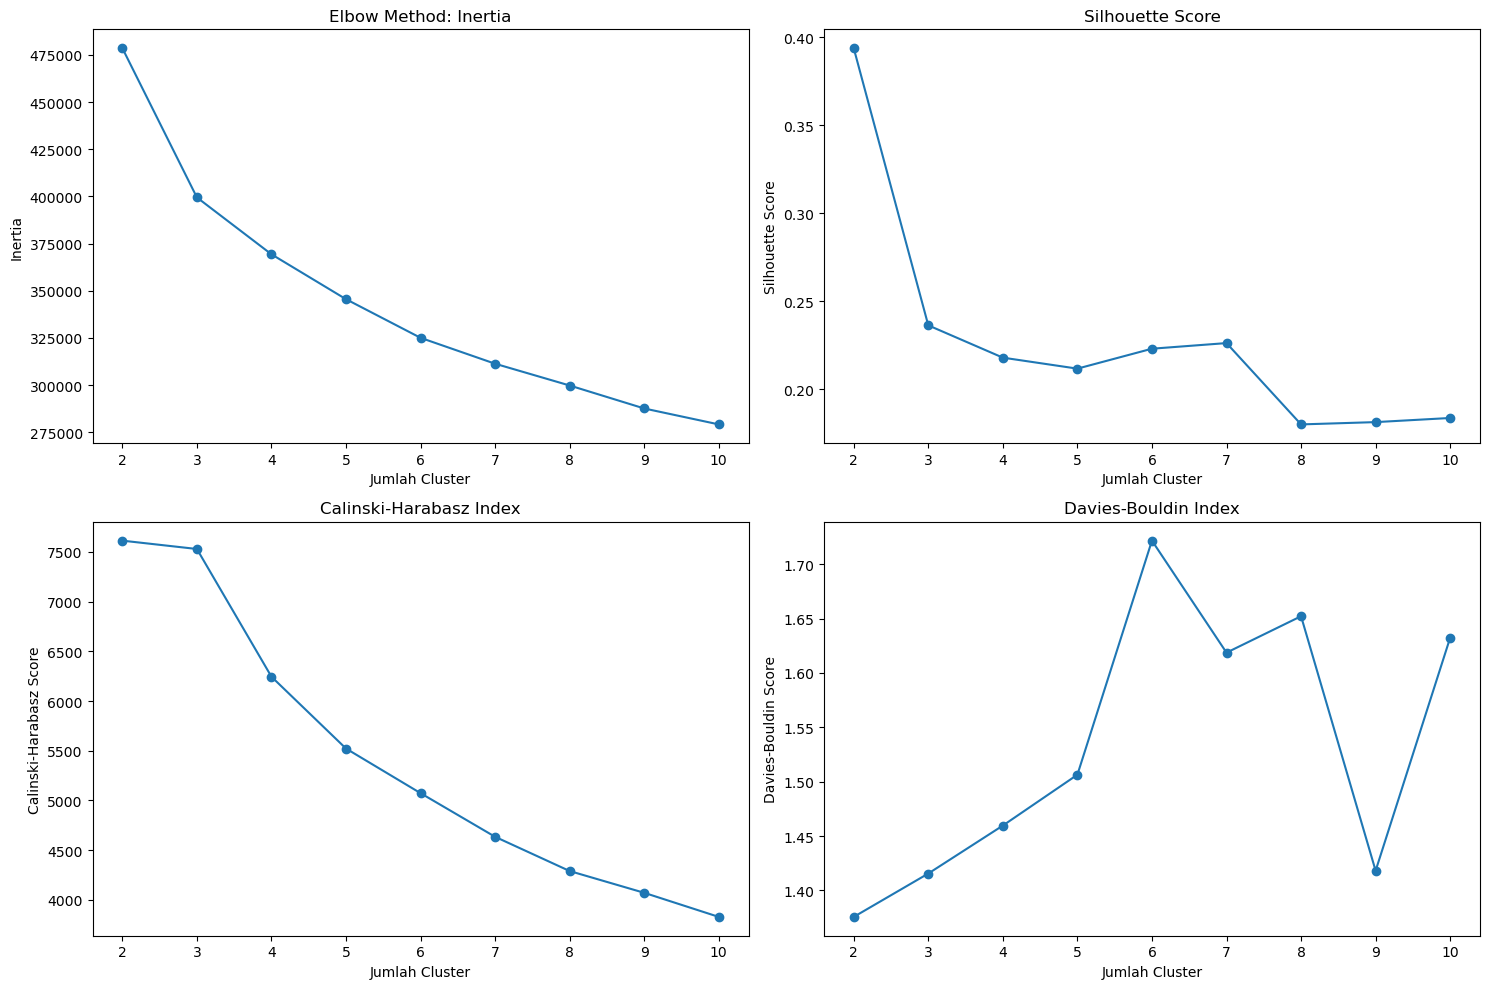


Jumlah Cluster Optimal berdasarkan Silhouette Score: 2.0

Stabilitas Clustering: 0.4082

Metrik performa clustering telah disimpan di 'clustering_performance_metrics.csv'


In [16]:
## Evaluasi Performa Clustering
# Fungsi untuk menghitung berbagai metrik performa clustering
def evaluate_clustering_performance(X_scaled, max_clusters=10):
    """
    Menghitung metrik performa clustering:
    1. Inertia (Within-Cluster Sum of Squares)
    2. Silhouette Score
    3. Calinski-Harabasz Index
    4. Davies-Bouldin Index
    """
    performance_metrics = {
        'n_clusters': [],
        'inertia': [],
        'silhouette_score': [],
        'calinski_harabasz_score': [],
        'davies_bouldin_score': []
    }
    
    for k in range(2, max_clusters + 1):
        # Lakukan clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        labels = kmeans.labels_
        
        # Simpan jumlah cluster
        performance_metrics['n_clusters'].append(k)
        
        # Inertia (Within-Cluster Sum of Squares)
        performance_metrics['inertia'].append(kmeans.inertia_)
        
        # Silhouette Score
        performance_metrics['silhouette_score'].append(
            silhouette_score(X_scaled, labels)
        )
        
        # Calinski-Harabasz Index (Higher is better)
        performance_metrics['calinski_harabasz_score'].append(
            calinski_harabasz_score(X_scaled, labels)
        )
        
        # Davies-Bouldin Index (Lower is better)
        performance_metrics['davies_bouldin_score'].append(
            davies_bouldin_score(X_scaled, labels)
        )
    
    return pd.DataFrame(performance_metrics)

# Hitung metrik performa clustering
performance_df = evaluate_clustering_performance(X_scaled)
print("Metrik Performa Clustering:")
print(performance_df)

## Visualisasi Metrik Performa
plt.figure(figsize=(15,10))

# Plot Inertia (Elbow Method)
plt.subplot(2,2,1)
plt.plot(performance_df['n_clusters'], performance_df['inertia'], marker='o')
plt.title('Elbow Method: Inertia')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(2,2,2)
plt.plot(performance_df['n_clusters'], performance_df['silhouette_score'], marker='o')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')

# Plot Calinski-Harabasz Index
plt.subplot(2,2,3)
plt.plot(performance_df['n_clusters'], performance_df['calinski_harabasz_score'], marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Calinski-Harabasz Score')

# Plot Davies-Bouldin Index
plt.subplot(2,2,4)
plt.plot(performance_df['n_clusters'], performance_df['davies_bouldin_score'], marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

## Tentukan Jumlah Cluster Optimal
# Berdasarkan berbagai metrik
optimal_clusters = performance_df.loc[
    performance_df['silhouette_score'].idxmax()
]['n_clusters']
print(f"\nJumlah Cluster Optimal berdasarkan Silhouette Score: {optimal_clusters}")

## Lakukan Clustering dengan Cluster Optimal
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

## Analisis Stabilitas Clustering
def clustering_stability(X_scaled, n_clusters, n_iterations=50):
    """
    Mengukur stabilitas clustering dengan menjalankan ulang clustering 
    beberapa kali dan mengukur konsistensi label cluster
    """
    all_labels = []
    
    for _ in range(n_iterations):
        # Clustering dengan random state berbeda
        kmeans = KMeans(n_clusters=n_clusters, random_state=None, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        all_labels.append(labels)
    
    # Hitung konsistensi label
    label_consistency = np.mean([
        np.mean(labels == all_labels[0]) for labels in all_labels[1:]
    ])
    
    return label_consistency

# Ukur stabilitas clustering
stability = clustering_stability(X_scaled, int(optimal_clusters))
print(f"\nStabilitas Clustering: {stability:.4f}")

## Simpan Hasil Performa
performance_df.to_csv('clustering_performance_metrics.csv', index=False)
print("\nMetrik performa clustering telah disimpan di 'clustering_performance_metrics.csv'")

In [13]:
## Simpan Hasil
# Simpan dataset dengan informasi cluster
df.to_csv('../data/credit_card_clustered_data.csv', index=False)
print("\nData telah disimpan dengan informasi cluster di 'credit_card_clustered_data.csv'")


Data telah disimpan dengan informasi cluster di 'credit_card_clustered_data.csv'
